# Lab:  Nonlinear Least-Squares 

In this lab, we will explore gradient descent for nonlinear least squares.  Our goal is to fit a nonlinear model of the form

     yhat ~= f(x,w) 
     
where `x` is a vector of features, `w` is a vector of parameters and `f` is a nonlinear function of `w`. 
To do this, we will seach for the parameters `w` that minimize the RSS cost 

     J(w) = \sum_i (y_i - f(x_i,w))^2
     
summed over training samples `(x_i,y_i)`.  This problem is known as nonlinear least-squares (NLLS).  In general, this optimization problem has no closed-form expression, and so gradient descent is widely used.  

In this lab, we will apply NLLS to a dataset from the National Institute of Standards.  In doing this lab, you will learn to:
* Set up a nonlinear least squares as an unconstrained optimization function
* Compute initial parameter estimates for a simple rational model
* Compute the gradients of the least squares objective
* Implement gradient descent for minimizing the objective
* Implement momentum gradient descent
* Visualize the convergence of the algorithm

We first import some key packages.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LinearRegression

## Load the Data

The NIST agency has an excellent [nonlinear regression website](https://www.itl.nist.gov/div898/strd/nls/nls_main.shtml) that has several datasets appropriate for nonlinear regression problems.  In this lab, we will use the data from a NIST study involving scanning electron microscope line width standards. 

You can download the data as follows.

In [23]:
url = 'https://itl.nist.gov/div898/strd/nls/data/LINKS/DATA/Kirby2.dat'
df = pd.read_csv(url, skiprows=60, sep=' ',skipinitialspace=True, names=['y0','x0','dummy'])
df

,y0,x0,dummy
0,0.0082,9.65,NaN
1,0.0112,10.74,NaN
2,0.0149,11.81,NaN
3,0.0198,12.88,NaN
4,0.0248,14.06,NaN
...,...,...,...
146,90.5500,360.20,NaN
147,90.9300,362.67,NaN
148,91.2000,364.53,NaN
149,91.5500,367.00,NaN


Extract the `x0` and `y0` into arrays.  Rescale `x0` and `y0` to values between `0` and `1` by dividing `x0` and `y0` by the maximum value.  Store the scaled values in vectors `x` and `y`.  The rescaling will help with the conditioning of the fitting.  Plot `y` vs. `x`. 

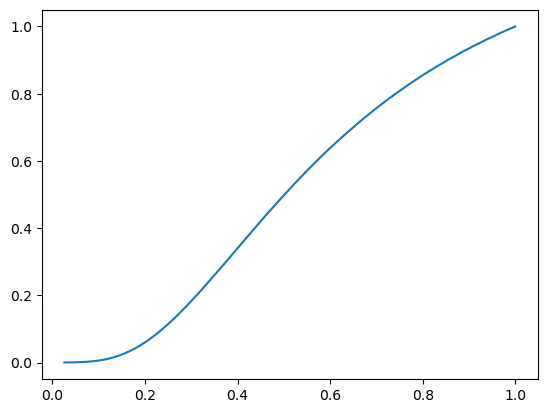

In [24]:
x0 = df['x0']
y0 = df['y0']
x = x0/np.max(x0)
y = y0/np.max(y0)
plt.plot(x, y)

To make the problem a little more challenging, we will add some noise.  Add random Gaussian noise with mean 0 and standard deviation = 0.05 to `y`.  Store the noisy results in `yn`. You can use the `np.random.normal()` function to add Gaussian noise. Plot `yn` vs. `x`.

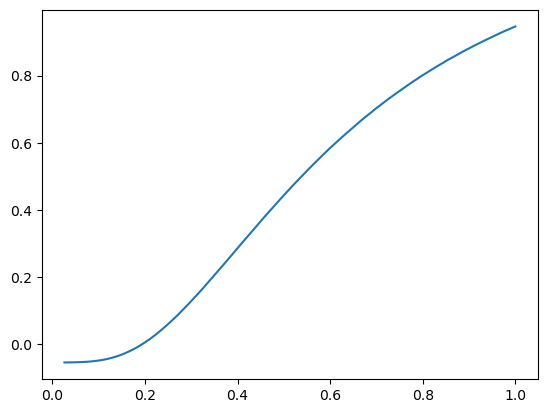

In [25]:
yn = y + np.random.normal(0, 0.05)
plt.plot(x, yn)

Split the data `(x,yn)` into training and test.  Let `xtr,ytr` be training data and `xts,yts` be the test data.  You can use the `train_test_split` function.  Set `test_size=0.33` so that 1/3 of the samples are held out for test.

In [27]:
from sklearn.model_selection import train_test_split

xtr, xts, ytr, yts = train_test_split(x, yn, test_size = 0.33)

## A Rational Model

The [NIST website](https://www.itl.nist.gov/div898/strd/nls/data/hahn1.shtml) suggests using a *rational* model of the form,

      yhat = (b[0] + b[1]*x + ... + b[d]*x^d)/(1 + a[0]*x + ... + a[m-1]*x^m)
      
with `d=3`.  The model parameters are `w = [a[0],...,a[m-1],b[0],...,b[d]]`, so there are `d+m+1` parameters total.
Complete the function below that takes vectors `w` and `x` and predicts a set of values `yhat` using the above model.
   

In [28]:
def predict(w,x,m):
    
    a = w[0: m]
    b = w[m:]
    
    aflip = np.flip(a)
    bflip = np.flip(b)
    arev = np.polyval(aflip, x) * x + 1
    brev = np.polyval(bflip, x)
    yhat = brev / arev
    
    return yhat

Every time you write a block of code, you should test/debug it before moving on. 
We can test our `predict` function by creating simple instances of `w`, `x`, `m`, `d` for which `yhat` is easily computed by hand. 
To do this, set `d=2=m` and `x=2` and run it at least once with `w` in `{[0,0,1,0,0],[0,0,0,1,0],[0,0,0,0,1],[1,0,1,0,0],[0,1,1,0,0]}` to be absolutely sure that your `predict` function is working as expected. 
Don't move on until this step is complete.

In [13]:
d = 2
m = 2
x = 2
w = [0,1,0,1,0]
yhat = predict(w,x,m)
print(yhat)

0.4


## Parameter Initialization

When we fit with a nonlinear model, most methods only obtain convergence to a *local* minimum, which is not necessarily good.  To converge to the *global* minimum, we need a good initialization.  For a rational model, one way to get a good initialization is to use the following trick.  First, realize that if

    y ~= (b[0] + b[1]*x + ... + b[d]*x^d)/(1 + a[0]*x + ... + a[m-1]*x^m)
    
then, by rearranging, we get

    y ~= - a[0]*y*x + ... - a[m-1]*y*x^m + b[0] + b[1]*x + ... + b[d]*x^d .
    
Note that this latter model is not useful for *prediction* of `y` from `x`. But it *is* useful for least-squares fitting the parameters `a` and `b` when you have a set of training samples of `x` and `y`.  

To do this least-squares fit, we can solve for parameter vector `w = [a,b]` using linear regression with the newly defined `i`th feature vector

    Z[i,:] = [ -y[i]*x[i]**1, ... , -y[i]*x[i]**m, x[i]**0, ... , x[i]**d ].
    
Make sure to use `fit_intercept = False` in `LinearRegression` because the `b[0]` term will act as the intercept.

As a hint, realize that a matrix with rows `[ x[i]**0, ... , x[i]**d]` can be efficiently created using broadcasting as `xtr[:,None]**jj[None,:]`, where `jj = [0,...,d]`.  For more on broadcasting, see the demo in Unit 0, especially the "outer product" section.  

In [68]:
d = 3
m = 2

kk = [[1], [2]] # the vector [1,...,m]
Z1 = np.transpose(-ytr * (xtr ** kk))  # so that Z2[i,k] = -y[i]*x[i]**(k+1)
jj = [[0], [1], [2], [3]] # the vector [0,...,d]
Z2 = np.transpose(xtr ** jj)  # so that Z1[i,j] = x[i]**j
Z = np.hstack((Z1, Z2))

# TODO.  Fit with parameters with linear regression
regr = LinearRegression(fit_intercept = False)
regr.fit(Z, ytr)

# Extract the parameters from regr.coef_ and store the parameter vector in winit
winit = regr.coef_

Now using the `predict` function and your initial parameter estimate `winit`, compute `yhat` for 1000 values of `x` uniformly spaced over the interval `[0,1]`.  Plot `yhat` versus `x`.  You should see that the prediction curve has some singularities (i.e., places where it goes to infinity).  On the same plot, superimpose the points `(xts,yts)`.  Use the `axis` command to restrict your plot to the interval between -0.1 and 1.1 for both `x` and `y`.

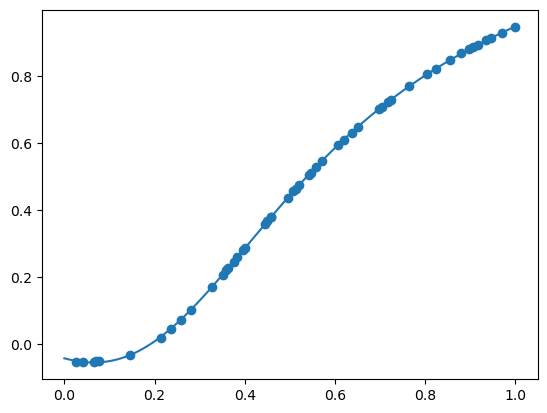

In [69]:
xp = np.linspace(0, 1, 1000)
yhat = predict(winit, xp, m)
plt.plot(xp, yhat)
plt.scatter(xts,yts)
xmin = ymin = -0.1
ymax = xmax = 1.1
xmin, xmax, ymin, ymax = plt.axis()

The problem with the prediction curve is that the denominator in our polynomial model for `yhat` goes to zero at certain values of `x` in `[0,1]`.  As a result, some of the `z` features become correlated, and the least-squares fit for `winit` includes relatively large coefficient values. To alleviate this problem, we can use Ridge regression instead of least-squares, in order to keep the `winit` parameters closer to zero.  Re-run the fit above with `Ridge` with `alpha = 2e-1`. You should see a much better (but not perfect) fit.

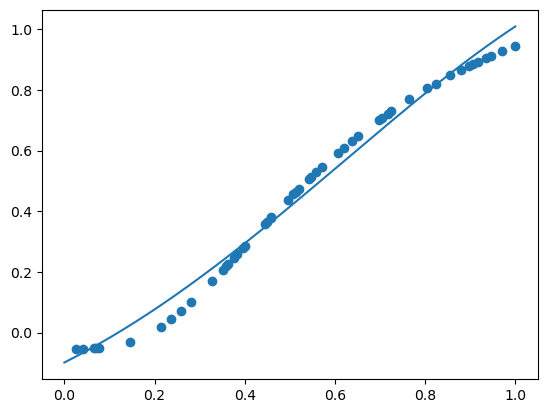

In [71]:
# TODO.  Fit with parameters with linear regression
regr = Ridge(alpha=2e-1,fit_intercept=False)
regr.fit(Z, ytr)

# TODO
# Extract the parameters from regr.coef_ 
winit = regr.coef_

# TODO
# Plot the results as above
xp = np.linspace(0, 1, 1000)
yhat = predict(winit, xp, m)
plt.plot(xp, yhat)
plt.scatter(xts,yts)
xmin = ymin = -0.1
ymax = xmax = 1.1
xmin, xmax, ymin, ymax = plt.axis()

## Implementing loss and gradient using Numpy broadcasting

We can now use gradient descent to improve our initial estimate of the weights `w` computed using ridge regression.  Complete the construction of the following function, which is used to compute the (scaled) RSS cost

    J(w) = \sum_i (y[i] - yhat[i])^2
    
and `Jgrad`, the gradient of `J(w)`.  Your code should use Numpy broadcasting and matrix/vector multiplies as needed, and no "for" loops.  It should be written as efficiently as possible, so that no computations are repeated unnecessarily.

In [137]:
def Jeval(w,x,y,m):
        
    a = w[0: m]
    b = w[m:]
    d = b.shape[0] - 1

    # TODO.  From vector x, use broadcasting to create matrix Xnum such that Xnum[i,j] = x[i]**j
    jj = np.arange(d + 1).reshape(d + 1, 1)
    Xnum = np.transpose(x ** jj)

    # TODO.  From vector x, use broadcasting to create matrix Xden such that Xden[i,k] = x[i]**(k+1)
    kk = np.arange(m).reshape(m, 1)
    kk = kk + 1
    Xden = np.transpose(x ** kk)
    
    # TODO.  Compute yhat using Xnum, Xden, a, and b
    yhat = (np.sum(np.multiply(Xnum, b))) / (np.sum(np.multiply(Xden, a)) + 1)
    
    # TODO.  Compute loss J from vectors y and yhat
    e = yhat-y
    J = np.sum(e ** 2)
    
    # TODO.  Compute loss gradient dJ/dw
    Jgrad = [2 * e * yhat / (np.sum(np.multiply(Xden, a)) + 1) * x, 2 * e * yhat / (np.sum(np.multiply(Xden, a)) + 1) * (x**2), ]
    
    return J, Jgrad

First, test the `yhat` steps in the code above by *temporarily* returning `yhat` and comparing it to the output of `predict`. I suggest using `w=winit`, a simple scalar `x` such as `x=np.array([2.])`, and an arbitrary `y` of the same length.  If it fails, you could try a simpler version of `w` to debug the problem.  Don't move on until this step is working.

In [138]:
_w = winit
_x=np.array([2., 3])
_y=np.random.rand(2)
J, Jgrad = Jeval(_w, _x, _y, m)
print(J, Jgrad)

5.530456218919323 [-3.25877881 -5.08723082]


Now that `yhat` is correctly computed, make sure `Jeval` returns only `J` and `Jgrad`, and comment out the test block above so that your notebook still runs without error.

Next, we will test the gradient computation in `Jeval`:
* Set `w0 = winit` and compute `J0,Jgrad0 = Jeval(w0,xtr,ytr)`
* Generate a random `w1` very close to `w0` and compute `J1,Jgrad1 = Jeval(w1,xtr,ytr)`
* Verify that `J1-J0` matches `Jgrad0.dot(w1-w0)` up to several digits of precision

Don't move on until this step is working.

In [139]:
w0 = winit
w1 = winit + (np.random.rand(6)/10-0.05)
J0, Jgrad0 = Jeval(w0, xtr, ytr, m)
J1, Jgrad1 = Jeval(w1, xtr, ytr, m)
print(J1-J0)
print(Jgrad0.dot(w1-w0))

33.61823589719188


ValueError: shapes (101,) and (6,) not aligned: 101 (dim 0) != 6 (dim 0)

## Implement gradient descent

We will now attempt to minimize the loss function using gradient descent.  Using the function `Jeval` defined above, implement gradient descent.  Run gradient descent with a step size of `alpha=1e-4` starting at `w=winit`.  Run it for `nit=100000` iterations.  Compute `Jgd[it]`, the cost attained by gradient descent at iteration `it`.  Plot `Jgd[it]` vs. `it` on a log-log scale.  

You should see that the training loss decreases but does not fully converge after 10000 iterations.

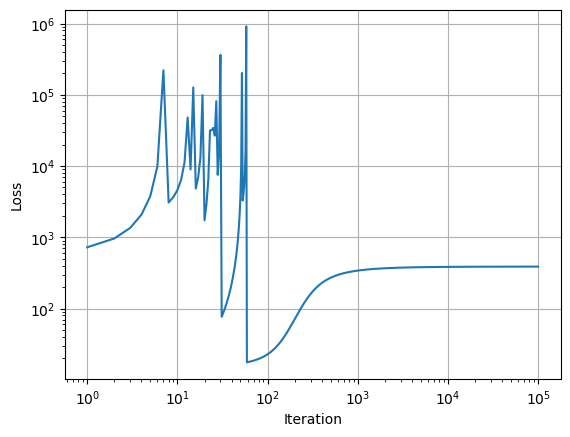

In [124]:
nit = 100000
step = 1e-4
def grad_opt_simp(Jeval, winit, lr=step, nit=nit):
    w0 = winit
    hist = {'w': [], 'J': []}
    
    for it in range(nit):
        J0, Jgrad0 = Jeval(w0, xtr, ytr, m)
        w0 = w0 - lr*Jgrad0
        hist['J'].append(J0)
        hist['w'].append(w0)
    for elem in ('J', 'w'):
        hist[elem] = np.array(hist[elem])
        
    return w0, J0, hist

w, J0, hist = grad_opt_simp(Jeval, winit, lr=step, nit=nit)

t = 1+np.arange(nit)
plt.loglog(t, hist['J'])
plt.grid()
plt.ylabel('Loss')
plt.xlabel('Iteration');

Now try to get a faster convergence using adaptive step-size via the Armijo rule. Implement Armijo gradient descent.  Let `Jadapt[it]` be the loss value that it attains on iteration `it`.  Plot `Jadapt[it]` and `Jgd[it]` vs. `it` on the same log-log graph.  You should see some improvement, but also some lingering problems.

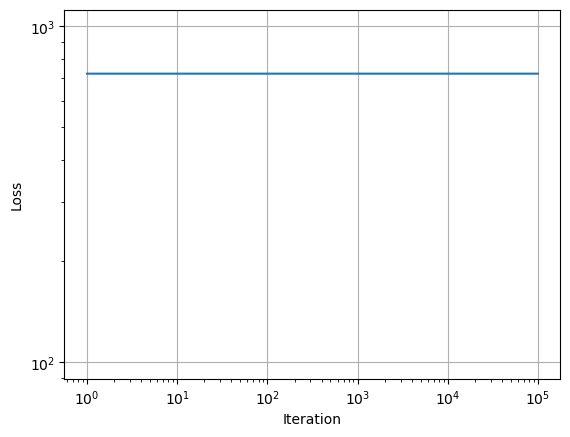

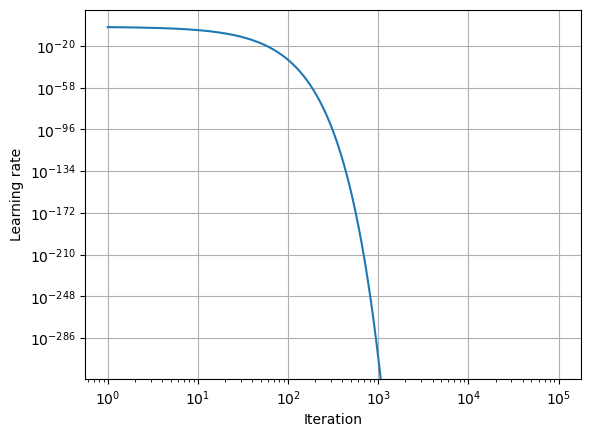

In [127]:
nit = 100000
step = 1e-3  # Initial step

def grad_opt_adapt(Jeval, winit, nit=1000, lr_init=1e-3, beta_incr=1.05, beta_decr=0.5, c=0.5):
    w0 = winit
    J0, Jgrad0 = Jeval(w0, xtr, ytr, m)
    lr = step
    
    # Create history dictionary for tracking progress per iteration.
    hist = {'w': [], 'J': [], 'lr': []}

    # Save history
    hist['w'].append(w0)
    hist['J'].append(J0)
    hist['lr'].append(lr)
    
    # Loop over GD iterations
    for it in range(nit):

        # Take a gradient step
        w1 = w0 - lr*Jgrad0
        J1, Jgrad1 = Jeval(w1, xtr, ytr, m)
        
        # Check if update passes the Armijo condition
        if (J1 < J0 - c*lr*np.linalg.norm(Jgrad0)**2):
            # If passes...
            w0 = w1 # accept the update
            J0 = J1 # accept the update
            Jgrad0 = Jgrad1 # accept the update
            lr = lr*beta_incr # increase learning rate
        else:
            # If fails...
            lr = lr*beta_decr # decrease learning rate
        
        # Save history
        hist['w'].append(w0)
        hist['J'].append(J0)
        hist['lr'].append(lr)
        
    # Convert dictionary to numpy arrays
    for elem in ('w', 'J', 'lr'):
        hist[elem] = np.array(hist[elem])
        
    return w0, J0, hist

w, J0, hist = grad_opt_adapt(Jeval, winit, nit=nit)

t = 1+np.arange(nit+1)
plt.loglog(t, hist['J'])
plt.grid()
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

plt.loglog(t, hist['lr'])
plt.grid()
plt.ylabel('Learning rate')
plt.xlabel('Iteration');

Using the final estimate for `w` from the adaptive step-size approach, plot the predicted value of `yhat` vs. `x` for 1000 values of `x` in `[0,1]`.  On the same plot, plot `yhat` vs. `x` for the initial parameter `w=winit`  computed using ridge regression.  Also, plot the test data, `yts` vs. `xts`.  You should see that gradient descent was able to improve the prediction model.

In [16]:
#TODO


## Momentum Gradient Descent

This section is optional.

One way to improve gradient descent is to use *momentum*.  With momentum, the gradient-descent update rule becomes:

    J, Jgrad = Jeval(w,...)
    z = beta*z + Jgrad
    w = w - step*z
    
This is similar to gradient descent, except that the update direction `z` is the sum of the gradient `Jgrad` and the previous update direction `z`, which tends to keep the algorithm moving in the same direction (instead of randomly changing directions, as it would if `z=Jgrad`).  Implement momentum gradient-descent with `beta = 0.95` and `step=1e-3`.  Compare the convergence of this approach to plain gradient descent and the adaptive stepsize version.  

In [17]:
# TODO
nit = 100000
step = 1e-3
beta = 0.95


Using the final estimate for `w` from the momentum approach, plot the predicted value of `yhat` vs. `x` for 1000 values of `x` in `[0,1]`.  On the same plot, plot `yhat` vs. `x` for the adaptive stepsize method.  Also, plot the test data, `yts` vs. `xts`.  

In [18]:
# TODO
